In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
import optuna

In [3]:
df = pd.read_csv('water_potability.csv')
df.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [4]:
df.dtypes
# df.isnull().any()

ph                 float64
Hardness           float64
Solids             float64
Chloramines        float64
Sulfate            float64
Conductivity       float64
Organic_carbon     float64
Trihalomethanes    float64
Turbidity          float64
Potability           int64
dtype: object

In [5]:
X = df.drop('Potability', axis=1)
y = pd.DataFrame(df['Potability'])

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=0)

sample_row = X.iloc[0,:].to_dict()

In [6]:
cols = X_train.columns

num_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean')),
    ('scale', StandardScaler())
])

preprocessing = ColumnTransformer(transformers=[
    ('num_pipeline', num_pipeline, cols)
])

model = XGBClassifier()

pipeline = Pipeline(steps=[
    ('transformer', preprocessing),
    ('model', model)
])

pipeline.fit(X_train, y_train)
preds = pipeline.predict(X_valid)

print(f'accuracy: {accuracy_score(y_valid, preds)}')

accuracy: 0.6429298067141404


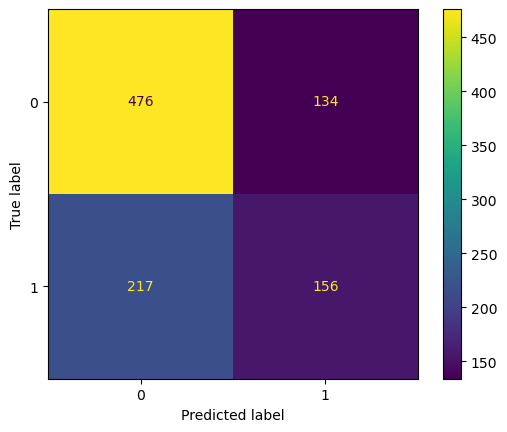

In [7]:
cm = confusion_matrix(y_valid, preds)
ConfusionMatrixDisplay(cm).plot()

# Optuna

In [12]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 20, 4000)
    booster = trial.suggest_categorical('booster', ['gbtree', 'gblinear', 'dart'])
    clf = XGBClassifier(n_estimators=n_estimators, booster=booster)
    pipeline = Pipeline(steps=[
        ('transformer', preprocessing),
        ('model', clf)
    ])
    pipeline.fit(X_train, y_train)
    return pipeline.score(X_valid, y_valid)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

model_params_list = ['n_estimators', 'booster']
model_params = dict()
for value, key in study.best_trial.params.items():
    if key in model_params_list:
        model_params[key] = value

clf = XGBClassifier(**model_params)
pipeline = Pipeline(steps=[
    ('transformer', preprocessing),
    ('model', clf)
])
pipeline.fit(X_train, y_train)

[I 2024-10-11 15:28:44,912] A new study created in memory with name: no-name-2a4db296-dde3-4b4b-97e9-99e212b2e395
[I 2024-10-11 15:39:12,492] Trial 0 finished with value: 0.6174974567650051 and parameters: {'n_estimators': 2428, 'booster': 'dart'}. Best is trial 0 with value: 0.6174974567650051.
[I 2024-10-11 15:39:12,759] Trial 1 finished with value: 0.6307222787385555 and parameters: {'n_estimators': 259, 'booster': 'gbtree'}. Best is trial 1 with value: 0.6307222787385555.
[I 2024-10-11 15:39:14,115] Trial 2 finished with value: 0.6144455747711088 and parameters: {'n_estimators': 2212, 'booster': 'gbtree'}. Best is trial 1 with value: 0.6307222787385555.
[I 2024-10-11 15:39:14,912] Trial 3 finished with value: 0.6225839267548321 and parameters: {'n_estimators': 3515, 'booster': 'gblinear'}. Best is trial 1 with value: 0.6307222787385555.
[I 2024-10-11 15:47:49,789] Trial 4 finished with value: 0.6154628687690743 and parameters: {'n_estimators': 2290, 'booster': 'dart'}. Best is tria

KeyboardInterrupt: 

In [9]:
import pickle

with open('pipeline.pkl', 'wb') as file:
    pickle.dump(pipeline, file)

In [10]:
from pydantic import BaseModel, ValidationError

class Water(BaseModel):
    ph: float
    Hardness: float
    Solids: float
    Chloramines: float
    Sulfate: float
    Conductivity: float
    Organic_carbon: float
    Trihalomethanes: float
    Turbidity: float

print(sample_row)
with open('pipeline.pkl', 'rb') as file:
    loaded_pipeline = pickle.load(file)

water = Water(**sample_row)
inputs = pd.DataFrame([water.model_dump()])
pred = loaded_pipeline.predict(inputs)[0]
pred


{'ph': nan, 'Hardness': 204.8904554713363, 'Solids': 20791.318980747023, 'Chloramines': 7.300211873184757, 'Sulfate': 368.51644134980336, 'Conductivity': 564.3086541722439, 'Organic_carbon': 10.3797830780847, 'Trihalomethanes': 86.9909704615088, 'Turbidity': 2.9631353806316407}


0

In [11]:
from flask import Flask, jsonify, request

app = Flask(__name__)

@app.route('/predict', methods=['POST'])
def predict():
    try:
        water = Water(**request.json)
        inputs = pd.DataFrame([water.model_dump()])
        pred = loaded_pipeline.predict(inputs)[0]
        response = {
            'prediction': int(pred)
        }
        return jsonify(response), 200
    except ValidationError as e:
        return jsonify(e.errors()), 400

if __name__=='__main__':
    app.run()

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [11/Oct/2024 15:28:23] "POST /predict HTTP/1.1" 200 -
